# ``SimpleConvNet2d`` Demo

The ``torch_tools.SimpleConvNet2d`` is a small, simple, 2D CNN model.

## Classifying handwritten digits — MNIST

The MNIST dataset contains greyscale images of `(28,28)` pixels containing handwritten digits between zero and nine. It is very easy to access the MNIST data through ``torchvision``—so much so that we don't even need to use the custom ``torch_tools.DataSet`` class.

So, let's get some digits!

### Demo env
Remember: the demo env requirements file—``demo-requirements.conda.yaml``—is different from the standard ``requirements.conda.yaml``. See ``README.md``.

In [1]:
from torchvision.datasets import MNIST
from torch import eye
from torchvision.transforms import Compose, ToTensor, RandomRotation
from torchvision.transforms import ColorJitter

import matplotlib.pyplot as plt

train_set = MNIST(
    "~/mnist_data/",
    download=True,
    train=True,
    transform=Compose(
        [
            ToTensor(),
            lambda x: x.repeat(3, 1, 1),
            RandomRotation(180.0),
            ColorJitter(brightness=0.1, hue=0.1, saturation=0.1, contrast=0.1),
        ]
    ),
    target_transform=Compose([lambda x: eye(10)[x]]),
)

valid_set = MNIST(
    "~/mnist_data/",
    download=True,
    train=False,
    transform=Compose([ToTensor(), lambda x: x.repeat(3, 1, 1)]),
    target_transform=Compose([lambda x: eye(10)[x]]),
)

print(len(train_set), len(valid_set))

60000 10000


Since we have done quite a few things here, let's break them down.

- The ``transform`` argument:
  - we supply a ``torchvision.transfroms.Compose`` object, which simply lets you chain callable objects to modify the images.
  - the first thing in the ``Compose`` is a ``torchvision.transforms.ToTensor``, which converts PIL images (or numpy image-like arrays) to ``torch.Tensor``s.
  - the second thing is the lambda function, which simply repeats the greyscale ``Tensor`` three times along the channel dimension. We do this because we are going to use a pretrained model which requires three input channels.
- The ``target_transform`` argument:
  - The target for each image is simply encoded as an integer. ``0`` means the image contains a zero, ``1`` means the image contains a one, etc. We convert these indices to one-hot encoded vectors with the lambda function supplued to ``target_transfrom``.

Let's look at a single example.

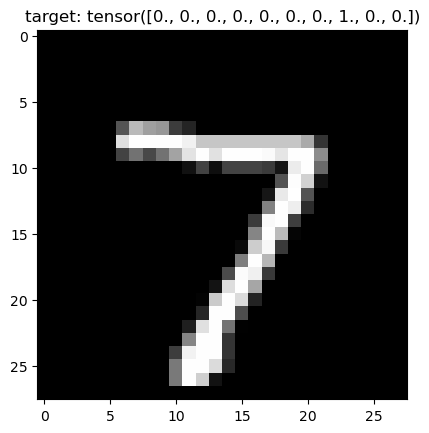

In [2]:
img, target = valid_set[0]

plt.imshow(img.permute(1, 2, 0))
plt.title(f"target: {target}")
plt.show()

This example is clearly a five, and the target is a one-hot vector encoding the fact that the ground truth is a five.

As before, we now wrap the datasets in ``torch.utils.data.DataLoader``.

In [3]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

As before, we need a model, optimiser and a loss function.

In [4]:
from torch_tools import SimpleConvNet2d
from torch.cuda import is_available

DEVICE = "cuda" if is_available() else "cpu"

model = SimpleConvNet2d(in_chans=3, out_feats=10).to(DEVICE)
print(model)

SimpleConvNet2d(
  (0): Encoder2d(
    (0): DoubleConvBlock(
      (0): ConvBlock(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ConvBlock(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConvBlock(
        (0): ConvBlock(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
        (1): ConvBlock(
          (0): Conv2d(128, 12

Now, lets set up a loss function and optimiser.

In [5]:
from torch.nn import BCELoss
from torch.optim import Adam

loss_func = BCELoss(reduction="sum")
optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

And now, the training and validation loops.

In [6]:
from torch import no_grad


def train_one_epoch(
    train_loader: DataLoader,
    loss_func: BCELoss,
    optimiser: Adam,
    model: SimpleConvNet2d,
):
    """Train the model for a single epoch.

    Parameters
    ----------
    train_loader : DataLoader
        A data loader supplying the training data.
    loss_func : BCELoss
        The loss function.
    optimiser : Adam
        Optimiser to fit the model with.
    model : SimpleConvNet2d
        Classification model.

    Returns
    -------
    mean_loss : float
        Mean loss per item.
    accuracy : float
        Fraction of inputs correctly classified.

    """
    model.train()
    running_loss = 0.0
    correct = 0
    for batch, targets in train_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        optimiser.zero_grad()

        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        loss.backward()

        optimiser.step()

        running_loss += loss.item()

        correct += (
            (preds.argmax(dim=1).detach().cpu() == targets.cpu().argmax(dim=1))
            .sum()
            .item()
        )

    mean_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)

    return mean_loss, accuracy


@no_grad()
def validate_one_epoch(
    valid_loader: DataLoader,
    loss_func: BCELoss,
    model: SimpleConvNet2d,
):
    """Validate the model for a single epoch.

    Parameters
    ----------
    valid_loader : DataLoader
        Validation data loader.
    loss_func : BCELoss
        Loss function
    model : SimpleConvNet2d
        Classification model.

    Returns
    -------
    mean_loss : float
        The mean loss per item.
    accuracy : float
        The fraction of correctly classified inputs.

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    for batch, targets in valid_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        running_loss += loss.item()

        correct += (
            (preds.argmax(dim=1).detach().cpu() == targets.argmax(dim=1).cpu())
            .sum()
            .item()
        )

    mean_loss = running_loss / len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset)

    return mean_loss, accuracy

Now we can train the model.

In [7]:
num_epochs = 20

training_loss, validation_loss = [], []
training_acc, validation_acc = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        train_loader,
        loss_func,
        optimiser,
        model,
    )
    valid_loss, valid_acc = validate_one_epoch(valid_loader, loss_func, model)

    training_loss.append(train_loss)
    training_acc.append(train_acc)

    validation_loss.append(valid_loss)
    validation_acc.append(valid_acc)

Now let's plot some simple performance metrics.

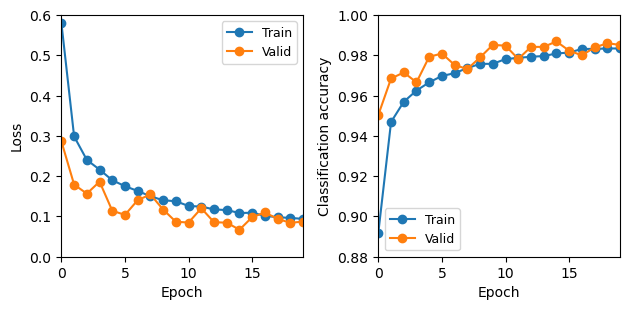

In [8]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(training_loss, "-o", label="Train")
axes[0].plot(validation_loss, "-o", label="Valid")

axes[1].plot(training_acc, "-o", label="Train")
axes[1].plot(validation_acc, "-o", label="Valid")


for axis in axes.ravel():
    axis.set_xlim(left=0, right=len(training_loss) - 1)
    axis.set_xlabel("Epoch")

axes[0].set_ylim(bottom=0.0, top=0.6)
axes[1].set_ylim(bottom=0.88, top=1.0)

for axis in axes.ravel():
    axis.set_aspect(
        (axis.get_xlim()[1] - axis.get_xlim()[0])
        / (axis.get_ylim()[1] - axis.get_ylim()[0]),
    )
    axis.legend(fontsize=9)

axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Classification accuracy")


fig.tight_layout()